# New York City Taxi Fare Prediction

[Source](https://jovian.com/aakashns/nyc-taxi-fare-prediction-filled)

![alt img](https://www.kaggle.com/competitions/10170/images/header)
We'll train a machine learning model to predict the fare for a taxi ride in New York city given information like pickup date & time, pickup location, drop location and no. of passengers.

Dataset Link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

##IMPORTS

In [1]:
pip install opendatasets --upgrade --quiet

In [4]:
pip install -U scikit-learn xgboost joblib --quiet

In [3]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

## 1. Download the Dataset




Dataset link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview


### Download Data from Kaggle

We'll use the opendatasets library: https://github.com/JovianML/opendatasets

In [ ]:
dataset_url = 'https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview'

In [ ]:
%%time
od.download(dataset_url)

Skipping, found downloaded files in "./new-york-city-taxi-fare-prediction" (use force=True to force download)
CPU times: user 679 µs, sys: 96 µs, total: 775 µs
Wall time: 874 µs


In [ ]:
data_dir = './new-york-city-taxi-fare-prediction'

### View Dataset Files

In [ ]:
# List of files with size
!ls -lh {data_dir}

total 5.4G
-rw-r--r-- 1 root root  486 Feb  5 18:41 GCP-Coupons-Instructions.rtf
-rw-r--r-- 1 root root 336K Feb  5 18:41 sample_submission.csv
-rw-r--r-- 1 root root 960K Feb  5 18:41 test.csv
-rw-r--r-- 1 root root 5.4G Feb  5 18:42 train.csv


In [ ]:
# Training set
!head {data_dir}/train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

In [ ]:
# Test set
!head {data_dir}/test.csv

key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320007324219,40.7638053894043,-73.981430053710938,40.74383544921875,1
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862182617188,40.719383239746094,-73.998886108398438,40.739200592041016,1
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.75126,-73.979654,40.746139,1
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.98116,40.767807,-73.990448,40.751635,1
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
2012-12-01 21:12:12.0000005,2012-12-01 21:12:12 UTC,-73.960983,40.765547,-73.979177,40.740053,1
2011-10-06 12:10:20.0000001,2011-10-06 12:10:20 UTC,-73.949013,40.773204,-73.959622,40.770893,1
2011-10-06 12:10:20.0000003,2011-10-06 12:10:20 UTC,-73.777282,40.646636,-73.985083,40.759368,1
2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.01409

In [ ]:
# No. of lines in training set
!wc -l {data_dir}/train.csv

55423856 ./new-york-city-taxi-fare-prediction/train.csv


In [ ]:
# No. of lines in test set
!wc -l {data_dir}/test.csv

9914 ./new-york-city-taxi-fare-prediction/test.csv


In [ ]:
# No. of lines in submission file
!wc -l {data_dir}/sample_submission.csv

9915 ./new-york-city-taxi-fare-prediction/sample_submission.csv


Observations:

- This is a supervised learning regression problem
- Training data is 5.5 GB in size
- Training data has 5.5 million rows
- Test set is much smaller (< 10,000 rows)
- The training set has 8 columns:
    - `key` (a unique identifier)
    - `fare_amount` (target column)
    - `pickup_datetime`
    - `pickup_longitude`
    - `pickup_latitude`
    - `dropoff_longitude`
    - `dropoff_latitude`
    - `passenger_count`
- The test set has all columns except the target column `fare_amount`.
- The submission file should contain the `key` and `fare_amount` for each test sample.


### Loading Training Set

Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:

- Ignore the `key` column
- Parse pickup datetime while loading data
- Specify data types for other columns
   - `float32` for geo coordinates
   - `float32` for fare amount
   - `uint8` for passenger count
- Work with a 1% sample of the data (~500k rows)

We can apply these optimizations while using [`pd.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [ ]:
# Change this
sample_frac = 0.01

In [ ]:
random.random()

0.6654800999740047

In [ ]:
# it tells how many time random value goes below 0.1
Count = 0
for idx in range(1000000):
  if random.random() < sample_frac:
    Count = Count + 1
print(Count)

9906


If skip_row(row_idx) returns True, that row is skipped (not loaded).
If it returns False, that row is loaded into the DataFrame.

In [ ]:
%%time
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac

random.seed(42)
df = pd.read_csv(data_dir+"/train.csv",
                 usecols=selected_cols,
                 dtype=dtypes,
                 parse_dates=['pickup_datetime'],
                 skiprows=skip_row)


CPU times: user 1min 14s, sys: 1.65 s, total: 1min 16s
Wall time: 1min 32s


In [ ]:
df.shape

(552450, 7)

### Load Test Set

For the test set, we'll simply provide the data types.

In [ ]:
test_df = pd.read_csv(data_dir+'/test.csv', dtype=dtypes, parse_dates=['pickup_datetime'])

In [ ]:
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6


## 2. Explore the Dataset



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float32            
 6   passenger_count    552450 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 15.3 MB


In [ ]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910500,-72.504326,39.934265,1.684983
std,9.810809,11.622035,8.041162,12.065184,9.226158,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


In [ ]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2009-01-01 00:11:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

Some observations about the test set:

- 9914 rows of data
- No missing values
- No obvious data entry errors
- 1 to 6 passengers (we can limit training data to this range)
- Latitudes lie between 40 and 42
- Longitudes lie between -75 and -72
- Pickup dates range from Jan 1st 2009 to Jun  30th 2015 (same as training set)

We can use the ranges of the test set to drop outliers/invalid data from the training set.

(array([4.70300e+03, 5.46026e+05, 1.56500e+03, 1.25000e+02, 2.00000e+01,
        6.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-52.        ,   3.09999847,  58.19999695, 113.29998779,
        168.3999939 , 223.5       , 278.59997559, 333.69998169,
        388.79998779, 443.8999939 , 499.        ]),
 <BarContainer object of 10 artists>)

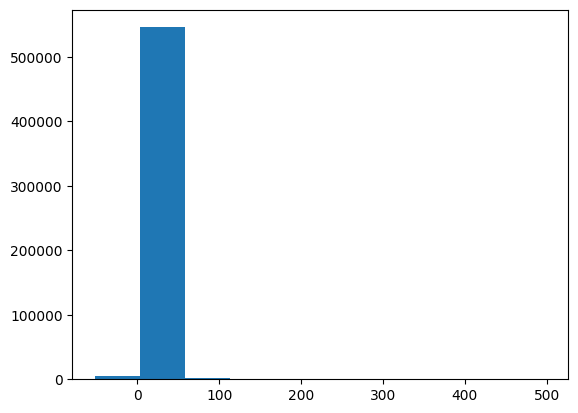

In [ ]:
plt.hist(df['fare_amount'], bins=10)

### Test Set

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


In [ ]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,0.042799,0.033542,0.039093,0.035436,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


In [ ]:
test_df.pickup_datetime.min(), test_df.pickup_datetime.max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

Some observations about the test set:

- 9914 rows of data
- No missing values
- No obvious data entry errors
- 1 to 6 passengers (we can limit training data to this range)
- Latitudes lie between 40 and 42
- Longitudes lie between -75 and -72
- Pickup dates range from Jan 1st 2009 to Jun  30th 2015 (same as training set)

We can use the ranges of the test set to drop outliers/invalid data from the training set.

<Axes: xlabel='fare_amount', ylabel='Count'>

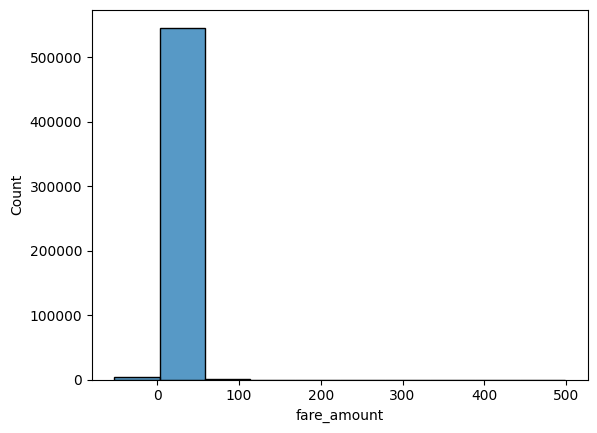

In [ ]:
sns.histplot(df['fare_amount'], bins=10)

In [ ]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## 3. Prepare Dataset for Training

- Split Training & Validation Set
- Fill/Remove Missing Values
- Extract Inputs & Outputs
   - Training
   - Validation
   - Test

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
len(train_df), len(val_df)

(441960, 110490)

### Fill/Remove Missing Values

There are no missing values in our sample, but if there were, we could simply drop the rows with missing values instead of trying to fill them (since we have a lot of training data)>

In [ ]:
df.isnull().sum()

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [ ]:
train_df = train_df.dropna()
val_df = val_df.dropna()

### Extract Inputs and Outputs

In [ ]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [ ]:
input_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [ ]:
target_col = 'fare_amount'

#### Training

In [ ]:
train_inputs = train_df[input_cols]

In [ ]:
train_targets = train_df[target_col]

In [ ]:
train_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
353352,-73.993652,40.741543,-73.977974,40.742352,4
360070,-73.993805,40.724579,-73.993805,40.724579,1
372609,-73.959160,40.780750,-73.969116,40.761230,1
550895,-73.952187,40.783951,-73.978645,40.772602,1
444151,-73.977112,40.746834,-73.991104,40.750404,2
...,...,...,...,...,...
110268,-73.987152,40.750633,-73.979073,40.763168,1
259178,-73.972656,40.764042,-74.013176,40.707840,2
365838,-73.991982,40.749767,-73.989845,40.720551,3
131932,-73.969055,40.761398,-73.990814,40.751328,1


In [ ]:
train_targets

,fare_amount
353352,6.0
360070,3.7
372609,10.0
550895,8.9
444151,7.3
...,...
110268,9.3
259178,18.5
365838,10.1
131932,10.9


#### Validation

In [ ]:
val_inputs = val_df[input_cols]

In [ ]:
val_targets = val_df[target_col]

In [ ]:
val_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
15971,-73.995834,40.759190,-73.973679,40.739086,1
149839,-73.977386,40.738335,-73.976143,40.751205,1
515867,-73.983910,40.749470,-73.787170,40.646645,1
90307,-73.790794,40.643463,-73.972252,40.690182,1
287032,-73.976593,40.761944,-73.991463,40.750309,2
...,...,...,...,...,...
467556,-73.968567,40.761238,-73.983406,40.750019,3
19482,-73.986725,40.755920,-73.985855,40.731171,1
186063,0.000000,0.000000,0.000000,0.000000,1
382260,-73.980057,40.760334,-73.872589,40.774300,1


In [ ]:
val_targets

,fare_amount
15971,14.000000
149839,6.500000
515867,49.570000
90307,49.700001
287032,8.500000
...,...
467556,6.100000
19482,7.300000
186063,4.500000
382260,32.900002


#### Test

In [ ]:
test_inputs = test_df[input_cols]

In [ ]:
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746140,1
3,-73.981163,40.767807,-73.990448,40.751637,1
4,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6
9910,-73.945511,40.803600,-73.960213,40.776371,6
9911,-73.991600,40.726608,-73.789742,40.647011,6
9912,-73.985573,40.735432,-73.939178,40.801731,6


## 4. Train Hardcoded & Baseline Models

- Hardcoded model: always predict average fare
- Baseline model: Linear regression

For evaluation the dataset uses RMSE error:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

### Train & Evaluate Hardcoded Model

Let's create a simple model that always predicts the average.

In [ ]:
class MeanRegressor():
  def fit(self, inputs, targets):
    self.mean = targets.mean()

  def predict(self,inputs):
    return np.full(inputs.shape[0],self.mean)

In [ ]:
model = MeanRegressor()

In [ ]:
model.fit(train_inputs,train_targets)

In [ ]:
model.mean

np.float32(11.354714)

In [ ]:
train_preds = model.predict(train_inputs)

In [ ]:
train_preds

array([11.354714, 11.354714, 11.354714, ..., 11.354714, 11.354714,
       11.354714], dtype=float32)

In [ ]:
val_preds = model.predict(val_inputs)

In [ ]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [ ]:
mean_squared_error(train_targets,train_preds)

95.83982849121094

In [ ]:
mean_squared_error(val_targets,val_preds)

98.00909423828125

In [ ]:
root_mean_squared_error(train_targets,train_preds)

9.78978157043457

In [ ]:
root_mean_squared_error(val_targets,val_preds)

9.899953842163086

### Train & Evaluate Baseline Model

We'll traina linear regression model as our baseline, which tries to express the target as a weighted sum of the inputs.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linreg_model = LinearRegression()

In [ ]:
linreg_model.fit(train_inputs, train_targets)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [ ]:
train_preds = linreg_model.predict(train_inputs)
train_preds

array([11.546237, 11.28461 , 11.28414 , ..., 11.458918, 11.284281,
       11.284448], dtype=float32)

In [ ]:
val_preds = linreg_model.predict(val_inputs)
val_preds

array([11.284328 , 11.284496 , 11.2847805, ..., 11.8045   , 11.284433 ,
       11.284133 ], dtype=float32)

In [ ]:
val_rmse = root_mean_squared_error(val_targets, val_preds)
val_rmse

9.898088455200195

In [ ]:
test_preds = linreg_model.predict(test_inputs)

## 6. Feature Engineering


- Extract parts of date
- Remove outliers & invalid data
- Add distance between pickup & drop
- Add distance from landmarks

Exercise: We're going to apply all of the above together, but you should observer the effect of adding each feature individually.

### Extract Parts of Date

- Year
- Month
- Day
- Weekday
- Hour


In [ ]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2
...,...,...,...,...,...,...,...
110268,9.3,2009-09-06 16:12:00+00:00,-73.987152,40.750633,-73.979073,40.763168,1
259178,18.5,2009-04-12 09:58:56+00:00,-73.972656,40.764042,-74.013176,40.707840,2
365838,10.1,2012-07-12 19:30:00+00:00,-73.991982,40.749767,-73.989845,40.720551,3
131932,10.9,2011-02-17 18:33:00+00:00,-73.969055,40.761398,-73.990814,40.751328,1


In [ ]:
pd.set_option('display.max_columns', 100)

In [ ]:
def add_dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [ ]:
add_dateparts(train_df, 'pickup_datetime')

In [ ]:
add_dateparts(val_df, 'pickup_datetime')

In [ ]:
add_dateparts(test_df, 'pickup_datetime')

| Number | Day of Week |
| :----: | :---------- |
|    0   | Monday      |
|    1   | Tuesday     |
|    2   | Wednesday   |
|    3   | Thursday    |
|    4   | Friday      |
|    5   | Saturday    |
|    6   | Sunday      |


In [ ]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1,2011,1,26,2,19
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1,2012,10,3,2,10
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1,2012,3,14,2,13
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2,2012,2,5,6,15
...,...,...,...,...,...,...,...,...,...,...,...,...
110268,9.3,2009-09-06 16:12:00+00:00,-73.987152,40.750633,-73.979073,40.763168,1,2009,9,6,6,16
259178,18.5,2009-04-12 09:58:56+00:00,-73.972656,40.764042,-74.013176,40.707840,2,2009,4,12,6,9
365838,10.1,2012-07-12 19:30:00+00:00,-73.991982,40.749767,-73.989845,40.720551,3,2012,7,12,3,19
131932,10.9,2011-02-17 18:33:00+00:00,-73.969055,40.761398,-73.990814,40.751328,1,2011,2,17,3,18


### Add Distance Between Pickup and Drop

We can use the haversine distance:
- https://en.wikipedia.org/wiki/Haversine_formula
- https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

In [ ]:


def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

In [ ]:
%%time
add_trip_distance(train_df)

CPU times: user 20.9 ms, sys: 1.95 ms, total: 22.8 ms
Wall time: 22.8 ms


In [ ]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3,1.323411
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1,2011,1,26,2,19,0.000000
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1,2012,10,3,2,10,2.325504
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1,2012,3,14,2,13,2.558912
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2,2012,2,5,6,15,1.243267
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,9.3,2009-09-06 16:12:00+00:00,-73.987152,40.750633,-73.979073,40.763168,1,2009,9,6,6,16,1.549976
259178,18.5,2009-04-12 09:58:56+00:00,-73.972656,40.764042,-74.013176,40.707840,2,2009,4,12,6,9,7.116529
365838,10.1,2012-07-12 19:30:00+00:00,-73.991982,40.749767,-73.989845,40.720551,3,2012,7,12,3,19,3.251601
131932,10.9,2011-02-17 18:33:00+00:00,-73.969055,40.761398,-73.990814,40.751328,1,2011,2,17,3,18,2.146101


In [ ]:
add_trip_distance(val_df)

In [ ]:
add_trip_distance(test_df)

### Add Distance From Popular Landmarks

- JFK Airport
- LGA Airport
- EWR Airport
- Times Square
- Met Meuseum
- World Trade Center

We'll add the distance from drop location.

In [ ]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

In [ ]:
def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])

In [ ]:
%%time
for a_df in [train_df, val_df, test_df]:
    for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)

CPU times: user 100 ms, sys: 1.98 ms, total: 102 ms
Wall time: 102 ms


In [ ]:
train_df.sample(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
137591,36.099998,2012-08-27 23:56:00+00:00,-73.872002,40.774158,-73.978645,40.759663,5,2012,8,27,0,23,9.119131,21.411846,9.012959,18.244272,2.549327,5.854754
542829,5.500000,2013-03-21 09:29:15+00:00,-73.959290,40.771702,-73.968231,40.762318,1,2013,3,21,3,9,1.286004,20.914553,8.094176,19.163347,1.944845,6.544806
22295,9.300000,2012-03-04 02:47:00+00:00,-73.983284,40.762634,-73.951859,40.781113,1,2012,3,4,6,2,3.348311,21.345215,6.568234,21.333162,0.973458,9.046823
475889,6.000000,2013-06-26 09:45:21+00:00,-74.003799,40.741756,-73.994621,40.750423,2,2013,6,26,2,9,1.234610,21.905355,10.570104,16.593750,4.166739,4.395515
388729,6.900000,2012-06-19 21:12:00+00:00,-73.957275,40.780426,-73.972916,40.763966,1,2012,6,19,1,21,2.253582,21.334871,8.447681,18.885799,1.899800,6.502335


### Remove Outliers and Invalid Data

There seems to be some invalide data in each of the following columns:

- Fare amount
- Passenger count
- Pickup latitude & longitude
- Drop latitude & longitude

In [ ]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910500,-72.504326,39.934265,1.684983
std,9.810809,11.622035,8.041162,12.065184,9.226158,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


In [ ]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273,2011.815816,6.857979,16.194170,2.852834,13.467420,3.433216,20.916754,9.675180,18.546659,4.512898,6.037652
std,0.042799,0.033542,0.039093,0.035436,1.278747,1.803347,3.353272,8.838482,1.994451,6.868584,3.969877,3.303940,3.295646,4.035816,4.018422,4.252535
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.401900,0.285629,0.284680,0.085747,0.040269
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,2010.000000,4.000000,9.000000,1.000000,8.000000,1.297261,20.513337,8.311565,16.520517,2.126287,3.670107
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,2012.000000,7.000000,16.000000,3.000000,15.000000,2.215648,21.181472,9.477797,18.024350,3.698123,5.541466
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,2014.000000,10.000000,25.000000,5.000000,19.000000,4.043051,21.909794,10.965272,19.880536,5.922544,7.757612
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,99.933281,134.497726,126.062576,149.400787,130.347153,138.619492


In [ ]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000
mean,11.354714,-72.498627,39.909996,-72.508141,39.937862,1.684444,2011.740038,6.263920,15.732492,3.035813,13.506568,19.751762,193.148026,182.365189,191.412308,177.416016,178.902115
std,9.788187,11.826187,8.449581,12.422503,9.833958,1.344170,1.857024,3.434881,8.697374,1.950033,6.517710,370.978485,1222.565186,1225.509888,1227.219604,1227.147827,1227.168091
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.305583,0.116402,0.129245,0.031195,0.009281
25%,6.000000,-73.992027,40.734859,-73.991409,40.733967,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.212447,20.535247,8.350981,16.502820,2.169769,3.642480
50%,8.500000,-73.981819,40.752613,-73.980171,40.753078,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.116254,21.202131,9.575539,18.016346,3.817937,5.559632
75%,12.500000,-73.967186,40.767006,-73.963715,40.768044,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.879624,21.948318,11.122054,19.953297,6.071617,7.814558
max,400.000000,2420.209473,404.899994,2467.752686,3351.403076,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,16913.427734,15057.673828,15074.642578,15074.713867,15077.615234,15072.110352


We'll use the following ranges:

- `fare_amount`: \$1 to \$500
- `longitudes`: -75 to -72
- `latitudes`: 40 to 42
- `passenger_count`: 1 to 6

In [ ]:
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) &
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) &
              (df['pickup_longitude'] <= -72) &
              (df['dropoff_longitude'] >= -75) &
              (df['dropoff_longitude'] <= -72) &
              (df['pickup_latitude'] >= 40) &
              (df['pickup_latitude'] <= 42) &
              (df['dropoff_latitude'] >=40) &
              (df['dropoff_latitude'] <= 42) &
              (df['passenger_count'] >= 1) &
              (df['passenger_count'] <= 6)]

In [ ]:
train_df = remove_outliers(train_df)

In [ ]:
val_df = remove_outliers(val_df)

### Save Intermediate DataFrames

Let's save the processed datasets in the Apache Parquet format, so that we can load them back easily to resume our work from this point.

You may also want to create differnt notebooks for EDA, feature engineering and model training.

In [ ]:
train_df.to_parquet('train.parquet')

In [ ]:
val_df.to_parquet('val.parquet')

In [ ]:
test_df.to_parquet('test.parquet')

## 7. Train & Evaluate Different Models

We'll train each of the following & submit predictions to Kaggle:

- Linear Regression
- Random Forests
- Gradient Boosting

Exercise: Train Ridge, SVM, KNN, Decision Tree models

In [ ]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [ ]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance']

In [ ]:
target_col = 'fare_amount'

In [ ]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

In [ ]:
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

In [ ]:
test_inputs = test_df[input_cols]

Let's define a helper function to evaluate models and generate test predictions

In [ ]:
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = root_mean_squared_error(train_targets, train_preds)
    val_preds = model.predict(val_inputs)
    val_rmse = root_mean_squared_error(val_targets, val_preds)
    return train_rmse, val_rmse, train_preds, val_preds

In [ ]:
def predict_and_submit(model, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv(data_dir+'/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
model1 = Ridge(random_state=42,alpha=0.9)

In [ ]:
%%time
model1.fit(train_inputs, train_targets)

CPU times: user 71.6 ms, sys: 45.6 ms, total: 117 ms
Wall time: 113 ms


,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",0.9
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",42


In [ ]:
model1.coef_

array([ 2.02026199e+01, -1.96283833e+01,  6.06587414e+00,  2.70386226e+01,
        2.95236401e-02,  5.35762503e-01,  7.66391251e-02,  3.56648539e-04,
       -4.99389780e-02,  1.82699721e-02,  1.80057911e+00, -2.66883379e-01,
       -4.21277131e-01, -1.38848177e+00,  6.31321403e-01,  1.07144837e+00])

In [ ]:
model1.intercept_

np.float64(594.2158194339647)

In [ ]:
evaluate(model1)

(5.049314043918831,
 5.217845618599148,
 array([ 8.12923647,  4.11617242,  8.75016006, ..., 10.47209139,
         8.2307147 , 10.5869553 ]),
 array([10.91913868,  6.20507267, 46.2188478 , ...,  8.04612766,
        25.56777317,  8.45283364]))

### Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
model2 = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42, n_estimators=50)

In [ ]:
%%time
model2.fit(train_inputs, train_targets)

CPU times: user 7min 20s, sys: 1.3 s, total: 7min 22s
Wall time: 4min 55s


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",50
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

In [ ]:
evaluate(model2)

(3.6022913838561528,
 4.167257655248953,
 array([ 7.06907907,  9.09651906,  9.09834234, ..., 10.39574834,
         7.73362485, 10.36404777]),
 array([12.53923917,  6.14414213, 47.3274893 , ...,  8.32839336,
        29.20883778,  8.27729971]))

In [ ]:
predict_and_submit(model2, 'rf_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.522156
1,2015-01-27 13:08:24.0000003,10.499965
2,2011-10-08 11:53:44.0000002,5.049496
3,2012-12-01 21:12:12.0000002,8.486169
4,2012-12-01 21:12:12.0000003,14.316837
...,...,...
9909,2015-05-10 12:37:51.0000002,8.873896
9910,2015-01-12 17:05:51.0000001,12.551152
9911,2015-04-19 20:44:15.0000001,55.266349
9912,2015-01-31 01:05:19.0000005,21.518925


### Gradient Boosting

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [ ]:
model3 = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')

In [ ]:
%%time
model3.fit(train_inputs, train_targets)

CPU times: user 14.3 s, sys: 56.9 ms, total: 14.3 s
Wall time: 18.1 s


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [ ]:
evaluate(model3)

(3.1664280891418457,
 3.9793801307678223,
 array([ 6.653713 ,  8.931815 , 10.276588 , ..., 12.1582575,  9.564414 ,
         9.845059 ], dtype=float32),
 array([14.876896 ,  5.986584 , 47.171738 , ...,  7.5201406, 30.39466  ,
         8.515031 ], dtype=float32))

## 8. Tune Hyperparmeters

https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76




In [ ]:


def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    model = ModelClass(**params).fit(train_inputs, train_targets)
    train_rmse = root_mean_squared_error(model.predict(train_inputs), train_targets)
    val_rmse = root_mean_squared_error(model.predict(val_inputs), val_targets)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], []
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)

    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [ ]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror'
}

### No. of Trees

In [ ]:
%%time
test_params(XGBRegressor, n_estimators=200, **best_params)

CPU times: user 26.1 s, sys: 90.3 ms, total: 26.2 s
Wall time: 28 s


(2.8878185749053955, 3.981048345565796)

CPU times: user 1min 38s, sys: 201 ms, total: 1min 38s
Wall time: 1min 7s


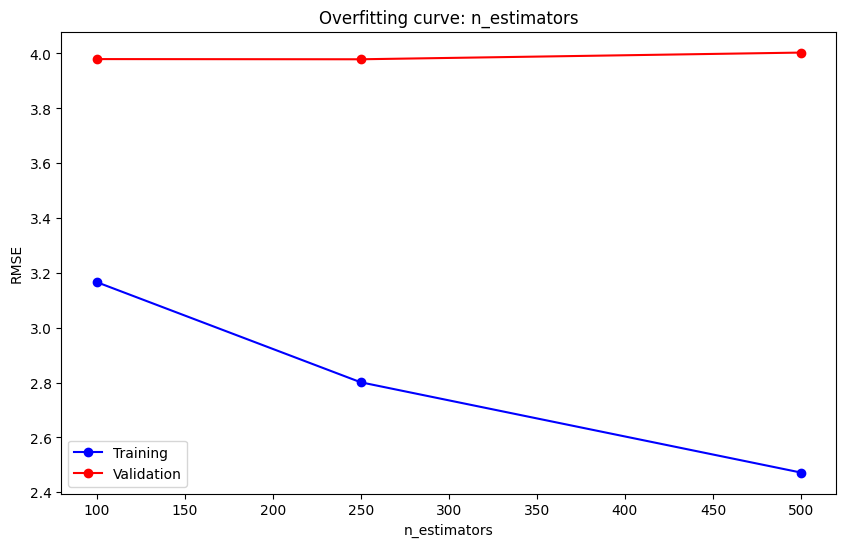

In [ ]:
%%time
test_param_and_plot(XGBRegressor, 'n_estimators', [100, 250, 500], **best_params)

Seems like 500 estimators has the lowest validation loss. However, it also takes a long time. Let's stick with 250 for now.

In [ ]:
best_params['n_estimators'] = 250

### Max Depth

CPU times: user 1min 9s, sys: 187 ms, total: 1min 9s
Wall time: 48.9 s


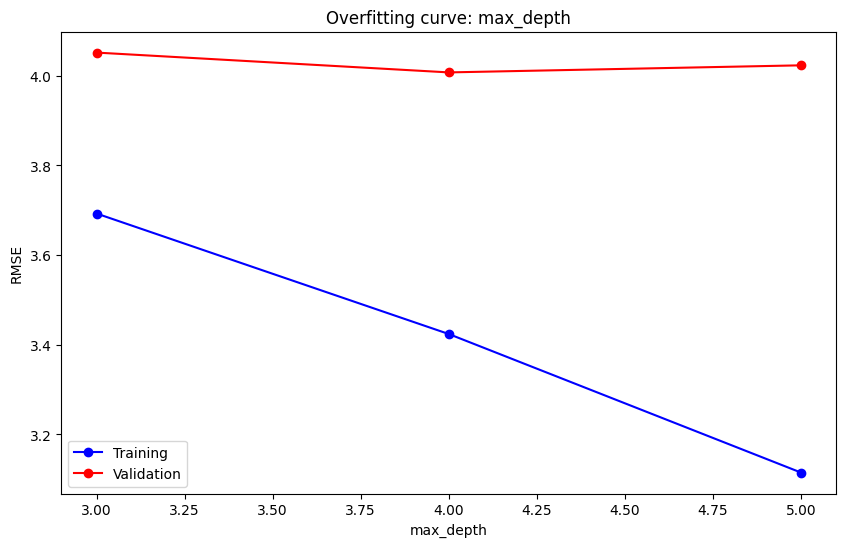

In [ ]:
%%time
test_param_and_plot(XGBRegressor, 'max_depth', [3, 4, 5], **best_params)

In [ ]:
best_params['max_depth'] = 4

### Learning Rate

CPU times: user 1min 1s, sys: 122 ms, total: 1min 1s
Wall time: 39.7 s


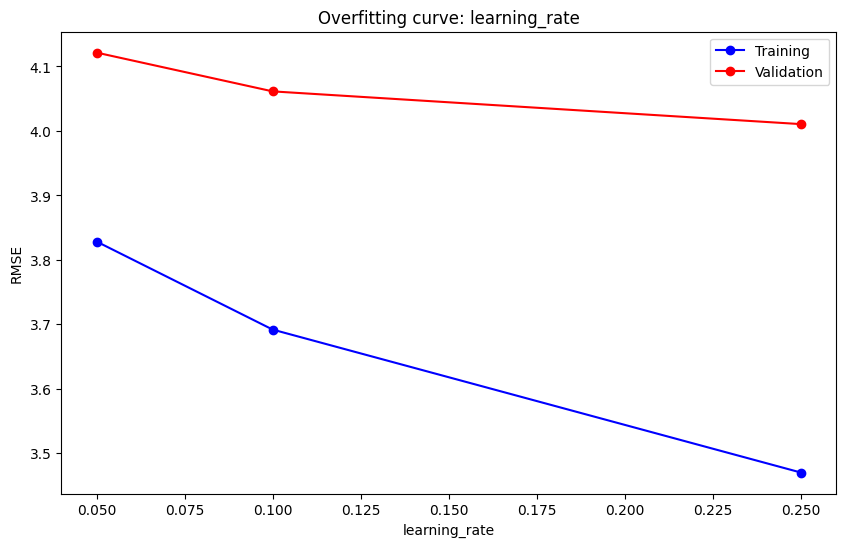

In [ ]:
%%time
test_param_and_plot(XGBRegressor, 'learning_rate', [0.05, 0.1, 0.25], **best_params)

In [ ]:
best_params['learning_rate'] = 0.25

### Other Parameters

Similarly we can experiment with other parameters.

Here's a set of parameters that works well:

In [ ]:
pipeline = Pipeline(steps=[
    ("model", XGBRegressor(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])


In [ ]:
xgb_model_final = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=500, max_depth=5, learning_rate=0.1,
                               subsample=0.8, colsample_bytree=0.8)

In [ ]:
%%time
pipeline.fit(train_inputs, train_targets)

CPU times: user 33 s, sys: 70.2 ms, total: 33 s
Wall time: 20.9 s


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8


In [ ]:
evaluate(pipeline)

(3.2278425693511963,
 3.992962121963501,
 array([ 6.530516,  8.074234,  9.734117, ..., 11.633722,  9.062087,
        10.267519], dtype=float32),
 array([14.877447,  5.890325, 48.2188  , ...,  7.223251, 30.275099,
         8.533674], dtype=float32))

In [ ]:
# For deployment
import joblib


In [ ]:
# joblib.dump(xgb_model_final, 'XGBRegressor_model.pkl')

In [ ]:
joblib.dump(
    {
        "pipeline": pipeline,
        "features": list(train_inputs.columns)
    },
    "taxi_fare_pipeline_bundle.pkl"
)

['taxi_fare_pipeline_bundle.pkl']

In [ ]:
from google.colab import files
files.download("taxi_fare_pipeline_bundle.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_loaded = joblib.load('XGBRegressor_model.pkl')

In [ ]:
evaluate(model_loaded) # ok its working perfactly

(3.2278425693511963,
 3.992962121963501,
 array([ 6.530516,  8.074234,  9.734117, ..., 11.633722,  9.062087,
        10.267519], dtype=float32),
 array([14.877447,  5.890325, 48.2188  , ...,  7.223251, 30.275099,
         8.533674], dtype=float32))